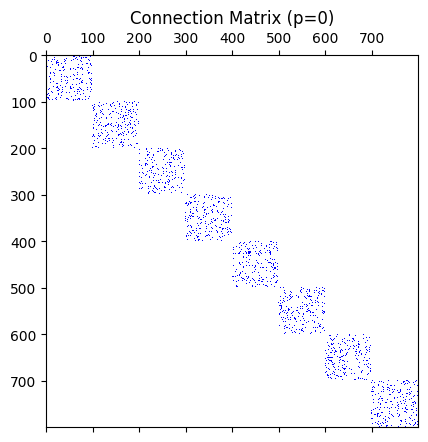

<Figure size 640x480 with 0 Axes>

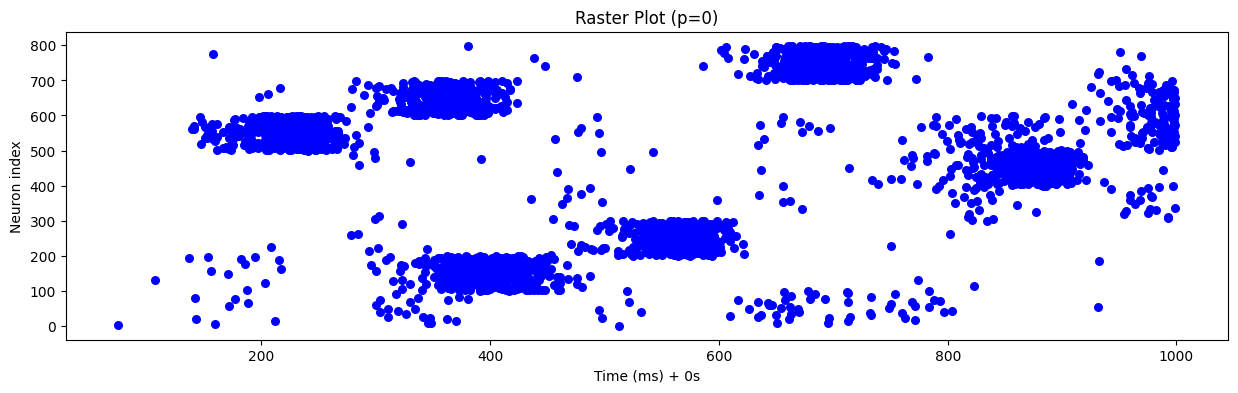

<Figure size 640x480 with 0 Axes>

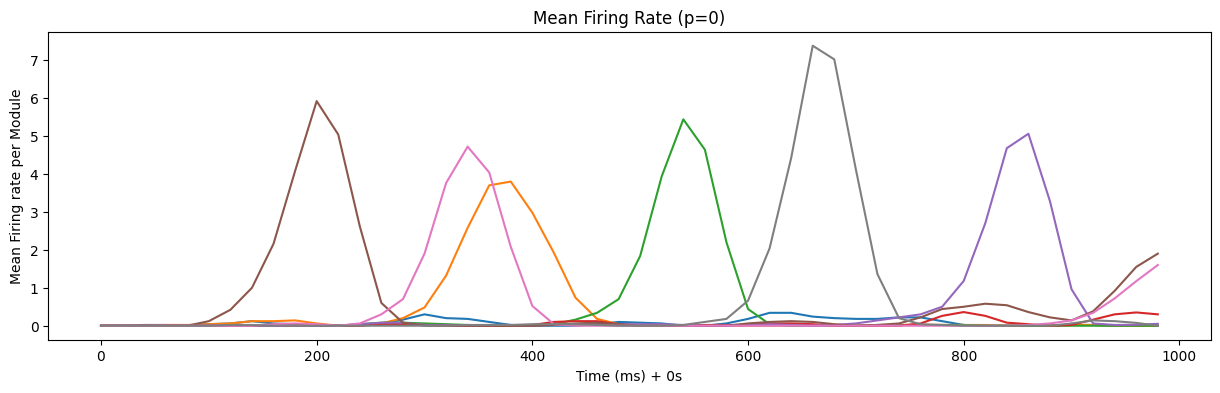

<Figure size 640x480 with 0 Axes>

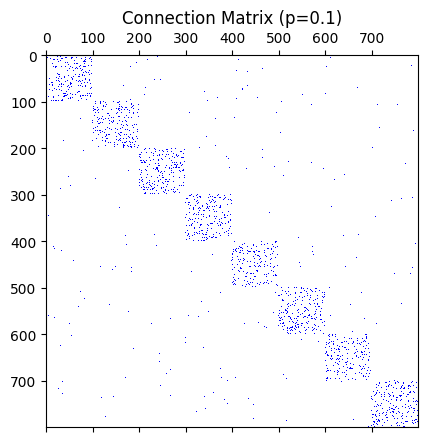

<Figure size 640x480 with 0 Axes>

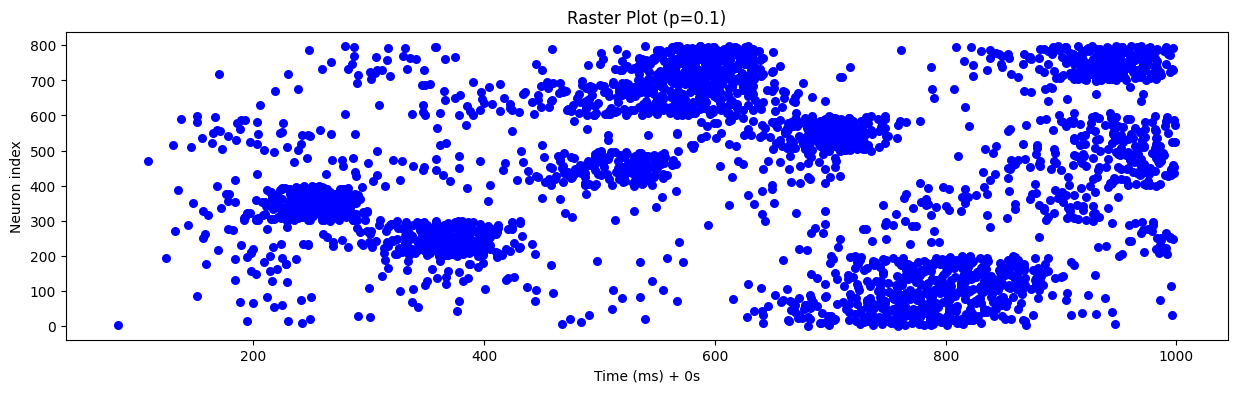

<Figure size 640x480 with 0 Axes>

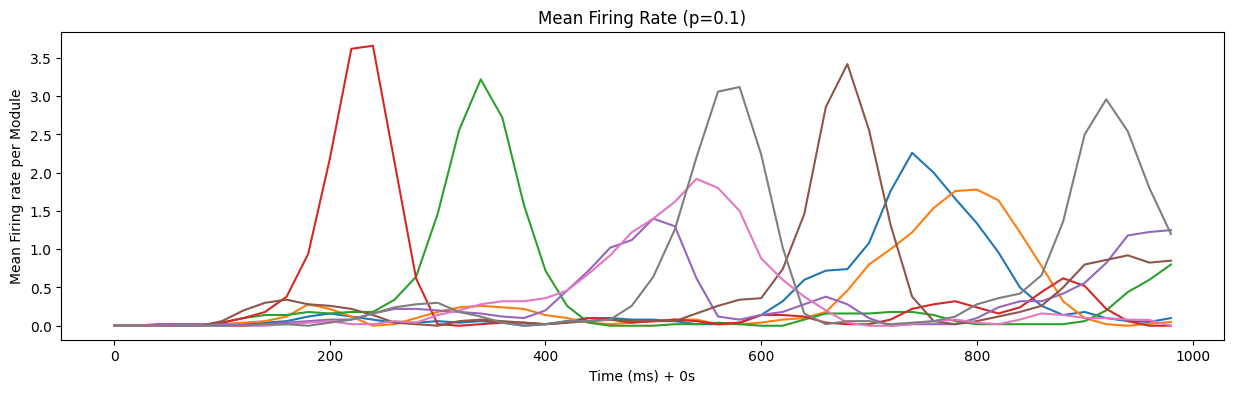

<Figure size 640x480 with 0 Axes>

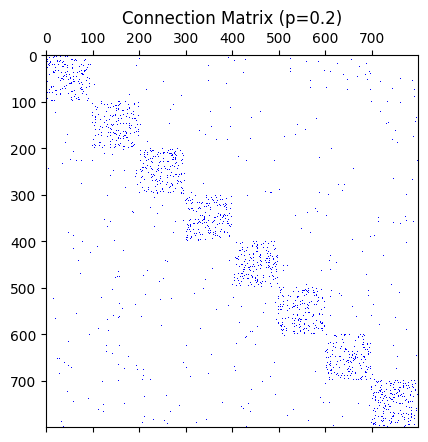

<Figure size 640x480 with 0 Axes>

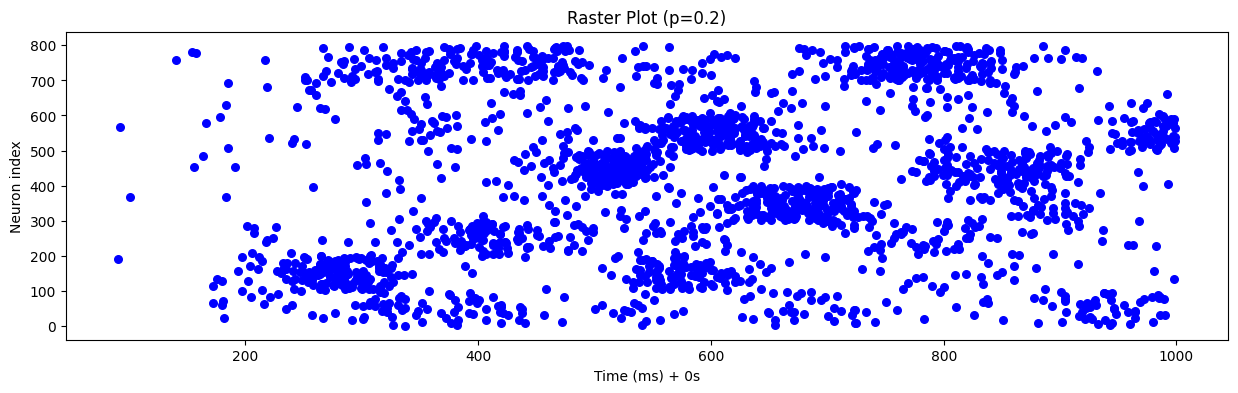

<Figure size 640x480 with 0 Axes>

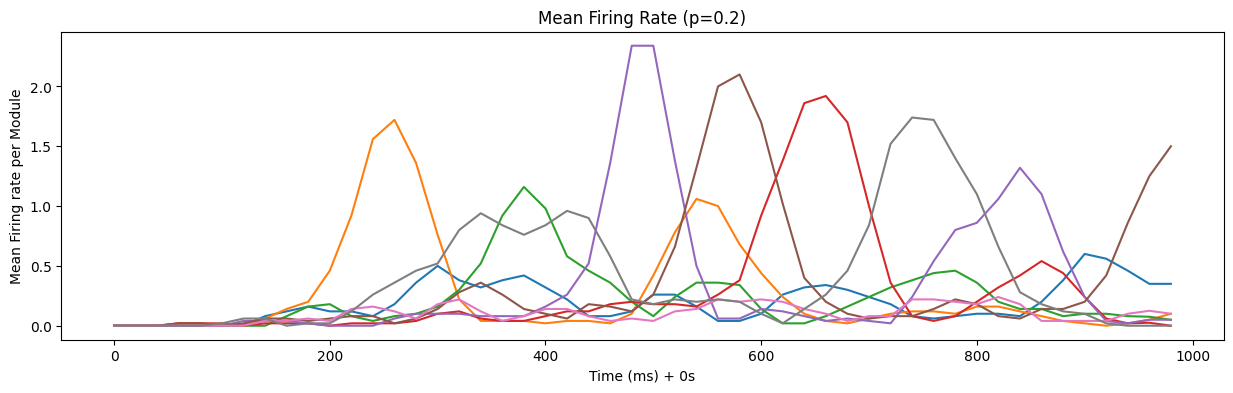

<Figure size 640x480 with 0 Axes>

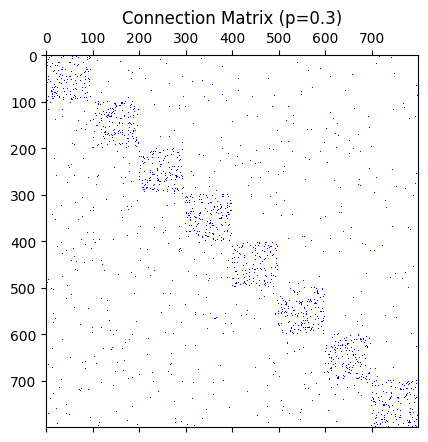

<Figure size 640x480 with 0 Axes>

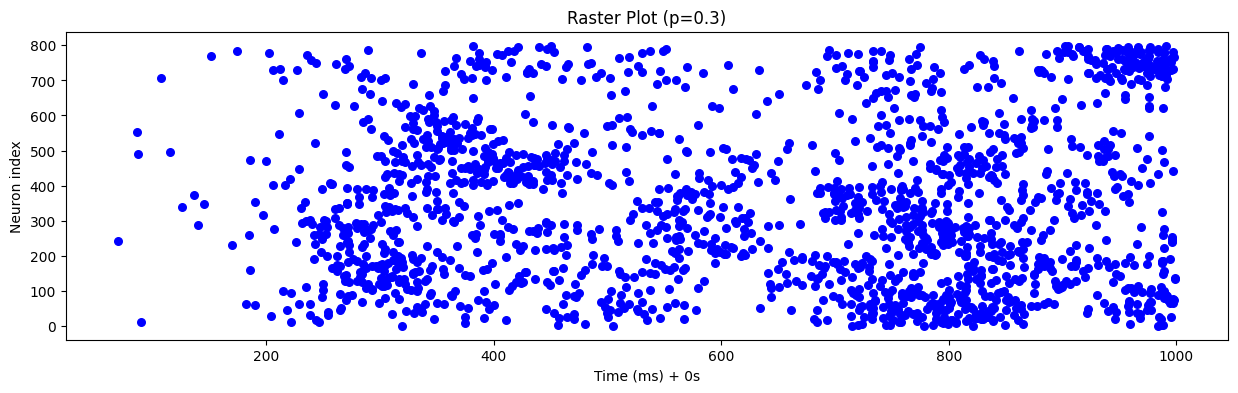

<Figure size 640x480 with 0 Axes>

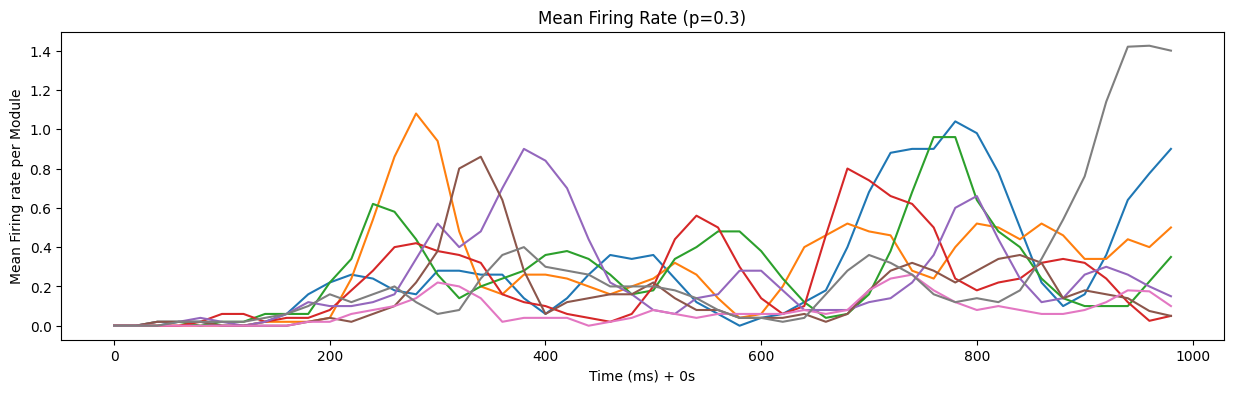

<Figure size 640x480 with 0 Axes>

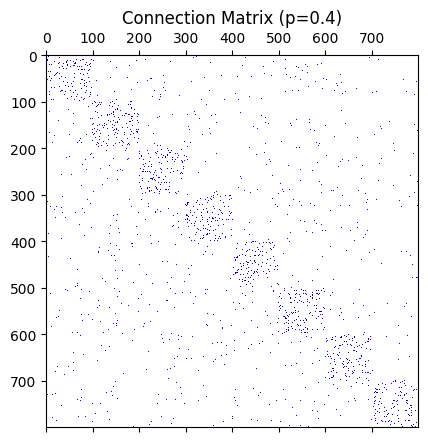

<Figure size 640x480 with 0 Axes>

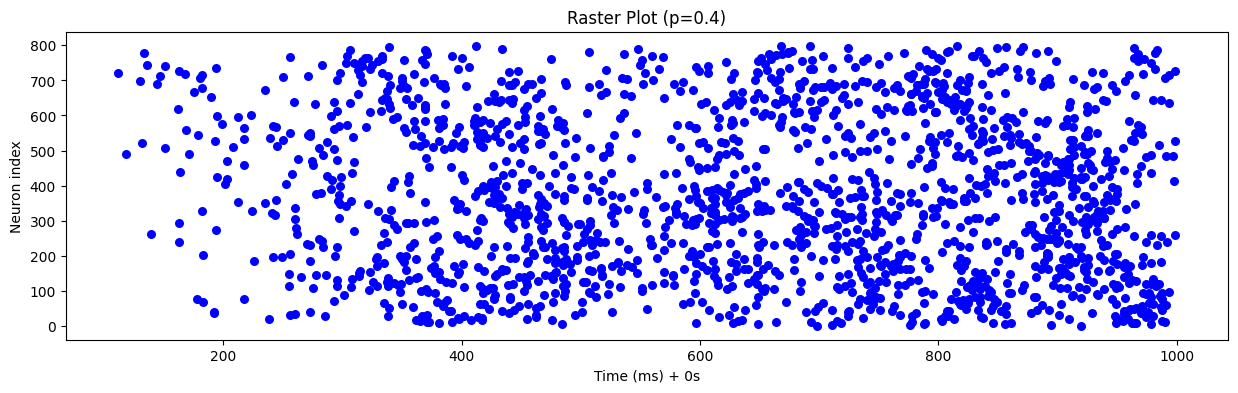

<Figure size 640x480 with 0 Axes>

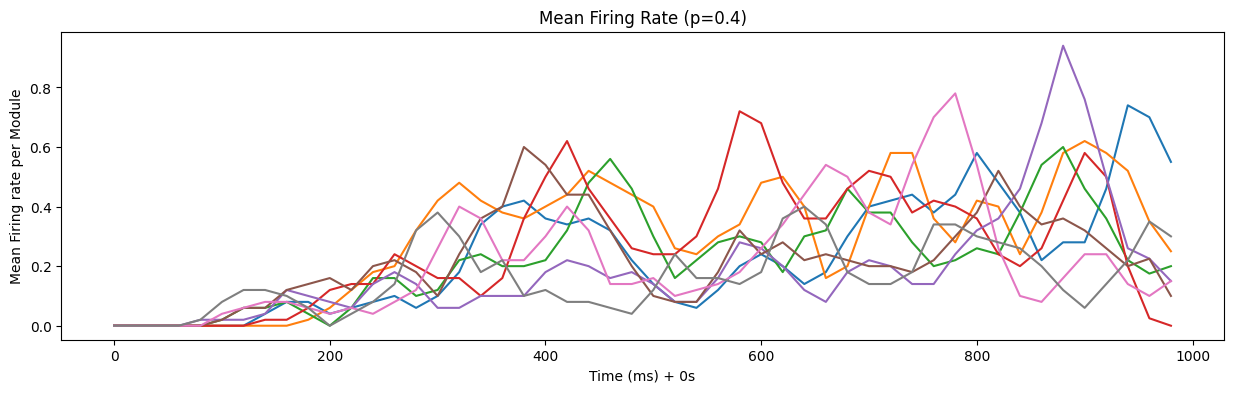

<Figure size 640x480 with 0 Axes>

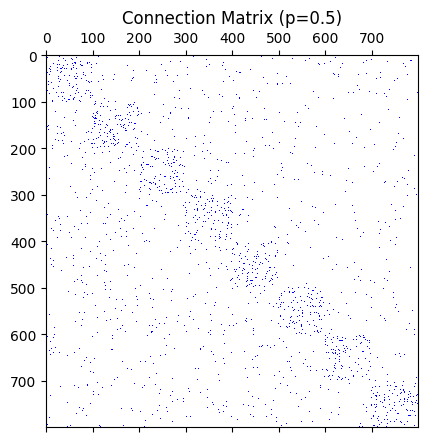

<Figure size 640x480 with 0 Axes>

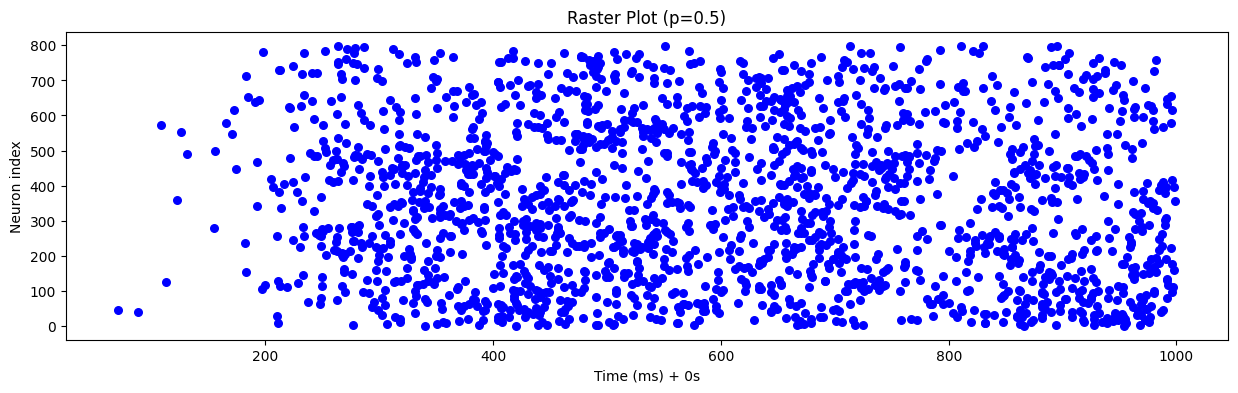

<Figure size 640x480 with 0 Axes>

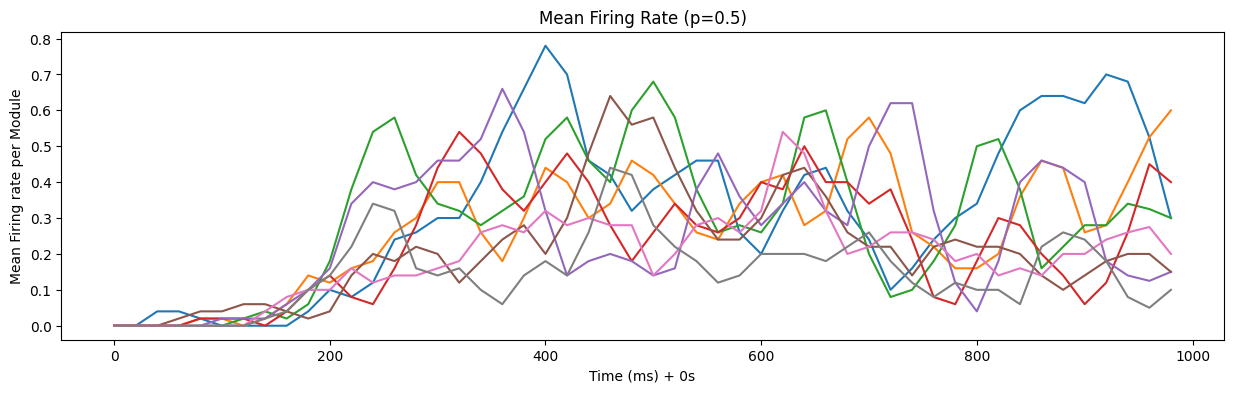

<Figure size 640x480 with 0 Axes>

In [32]:
from iznetwork import IzNetwork
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

class SmallWorldModularNetwork(object):
    """
    This class is used to simulate a small-world modular network
    """

    def __init__(self, p):
        """
        Initialise network with given rewiring probability

        Inputs:
        p     -- Rewiring probability
        """
        self.N_MODULE = 8
        self.N_MODULE_EXCITATORY = 100
        self.N_EXCITATORY = self.N_MODULE_EXCITATORY * self.N_MODULE
        self.N_INHIBITORY = 200

        self.N_MODULE_EDGE = 1000

        self.N = self.N_INHIBITORY + self.N_EXCITATORY

        self.EtoE_SCALING_FACTOR = 17
        self.EtoI_SCALING_FACTOR = 50
        self.ItoE_SCALING_FACTOR = 2
        self.ItoI_SCALING_FACTOR = 1

        Dmax = 20
        self.net = IzNetwork(self.N, Dmax)

        # Conduction Delay
        D = np.ones((self.N,self.N), dtype=int)
        D[:self.N_EXCITATORY, :self.N_EXCITATORY] = np.random.uniform(1, 20, size=(self.N_EXCITATORY, self.N_EXCITATORY))

        # Neurons Parameters
        a = np.zeros(self.N)
        b = np.zeros(self.N)
        c = np.zeros(self.N)
        d = np.zeros(self.N)
        
        # # Excitatory
        a[:self.N_EXCITATORY] = 0.02
        b[:self.N_EXCITATORY] = 0.2
        c[:self.N_EXCITATORY] = -65 + 15 * (np.random.rand(self.N_EXCITATORY) ** 2)
        d[:self.N_EXCITATORY] = 8 - 6 * (np.random.rand(self.N_EXCITATORY) ** 2)

        # # Inhibitory
        a[self.N_EXCITATORY:] = 0.02 + 0.08 * np.random.rand(self.N_INHIBITORY)
        b[self.N_EXCITATORY:] = 0.25 - 0.05 * np.random.rand(self.N_INHIBITORY)
        c[self.N_EXCITATORY:] = -65
        d[self.N_EXCITATORY:] = 2

        # Set connectivity
        self.W = np.zeros((self.N,self.N))

        # Connect Modular Excitatory-excitatory (1000 Connections)
        for i in range(self.N_MODULE):
            matrix = np.zeros((self.N_MODULE_EXCITATORY, self.N_MODULE_EXCITATORY))

            # All index pairs excluding self-connections
            all_pairs = [(row, col) for row in range(self.N_MODULE_EXCITATORY) 
                        for col in range(self.N_MODULE_EXCITATORY) if row != col]
            
            selected_pairs = random.sample(all_pairs, self.N_MODULE_EDGE)
            for row, col in selected_pairs:
                matrix[row, col] = 1
            
            self.W[i * self.N_MODULE_EXCITATORY:(i + 1) * self.N_MODULE_EXCITATORY, i * self.N_MODULE_EXCITATORY:(i + 1) * self.N_MODULE_EXCITATORY] = matrix

        # Connect Excitatory-inhibitory (4 to 1)
        for i in range(self.N_INHIBITORY):
            for index in range(4):
                self.W[i * 4 + index][self.N_EXCITATORY + i] = random.uniform(0.0, 1.0)
            
        # Connect Inhibitory-excitatory
        self.W[self.N_EXCITATORY:, :self.N_EXCITATORY] = np.random.uniform(-1, 0, size=(self.N_INHIBITORY, self.N_EXCITATORY))
        
        # Connect Inhibitory-inhibitory
        self.W[self.N_EXCITATORY:, self.N_EXCITATORY:] = np.random.uniform(-1, 0, size=(self.N_INHIBITORY, self.N_INHIBITORY))
        # Avoid Inhibitory-inhibitory self-connections
        np.fill_diagonal(self.W[self.N_EXCITATORY:, :self.N_EXCITATORY], 0)

        # Rewire Excitatory-excitatory
        for s in range(self.N_EXCITATORY):
            for t in range(self.N_EXCITATORY):
                # Have connection
                if self.W[s, t] == 0:
                    continue

                if np.random.random() < p:
                    self.W[s, t] = 0

                    new_target = s
                    while s // self.N_MODULE_EXCITATORY == new_target // self.N_MODULE_EXCITATORY:
                        new_target = np.random.randint(self.N_EXCITATORY)

                    self.W[s, new_target] = 1
        
        # Include Scaling Factor
        self.W[:self.N_EXCITATORY, :self.N_EXCITATORY] *= self.EtoE_SCALING_FACTOR
        self.W[:self.N_EXCITATORY, self.N_EXCITATORY:] *= self.EtoI_SCALING_FACTOR
        self.W[self.N_EXCITATORY:, :self.N_EXCITATORY] *= self.ItoE_SCALING_FACTOR
        self.W[self.N_EXCITATORY:, self.N_EXCITATORY:] *= self.ItoI_SCALING_FACTOR

        self.net.setDelays(D)
        self.net.setParameters(a, b, c, d)
        self.net.setWeights(self.W)

    def connection_matrix(self):
        """
        Plot Connection Matrix
        """

        # Connectivity Plot
        colors = ['white', 'blue'] 
        cmap = mcolors.LinearSegmentedColormap.from_list('white_blue', colors)
        plt.matshow(self.W[:self.N_EXCITATORY, :self.N_EXCITATORY], cmap=cmap)
        plt.title(f"Connection Matrix (p={p})")
        plt.show()
        plt.savefig(f"connection_matrix_{p}.png")

        # Weights Plot
        # vmin, vmax = self.W.min(), self.W.max()
        # norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        # colors = ['red', 'white', 'blue'] 
        # cmap = mcolors.LinearSegmentedColormap.from_list('red_white_blue', colors)
        # plt.matshow(self.W, cmap=cmap, norm=norm, interpolation='nearest')
        # plt.colorbar(label="Value")
        # plt.title(f"Connection Matrix (p={p})")
        # plt.show()

    def simulate(self):
        """
        Simulate network for 1000ms and plot Raster Plot and Mean Firing Rate per Module
        """
        # Raster Plot
        poissonLambda = 0.01
        T = 1000
        V = np.zeros((T, self.N))
        for t in range(T):
            self.net.setCurrent((np.random.poisson(poissonLambda, self.N) > 0) * 15)
            self.net.update()
            V[t,:], _ = self.net.getState()

        t, n = np.where(V[:,:self.N_EXCITATORY] > 29)
        plt.figure(figsize=(15, 4))
        plt.scatter(t, n, s=30, c='blue')
        plt.xlabel('Time (ms) + 0s')
        plt.ylabel('Neuron index')
        plt.title(f"Raster Plot (p={p})")
        plt.show()
        plt.savefig(f"raster_plot_{p}.png")

        # Mean Firing Rate
        interval = 20
        MFR = np.zeros((T // interval, self.N_MODULE))
        window = 50
        for t in range(0, T, interval):
            for m in range(self.N_MODULE):
                matrix = V[t:t+window, m * self.N_MODULE_EXCITATORY:(m+1) * self.N_MODULE_EXCITATORY]
                MFR[t // interval][m] = np.count_nonzero(matrix > 29) / matrix.shape[0]

        plt.figure(figsize=(15, 4))
        plt.plot(range(0, T, interval), MFR[:])
        plt.xlabel('Time (ms) + 0s')
        plt.ylabel('Mean Firing rate per Module')
        plt.title(f"Mean Firing Rate (p={p})")
        plt.show()
        plt.savefig(f"mean_firing_rate_{p}.png")

p_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
for p in p_values:
    network = SmallWorldModularNetwork(p=p)
    network.connection_matrix()
    network.simulate()


        